In [1]:
# pip install Path   # conda activate pyclass

In [2]:
import numpy as np ; import matplotlib as mpl ; import matplotlib.pyplot as plt ; import pandas as pd
import flopy ; from flopy.plot import styles;  from pathlib import Path; import os 
exe_name_mf = 'E:\\15_REPOS\\00_BETAMI\\w10_______others\\bin\\mf2005.exe'
exe_name_mt = 'E:\\15_REPOS\\00_BETAMI\\w10_______others\\bin\\mt3d-usgs_1.1.0_64.exe'
current_directory = os.getcwd();  print(current_directory)

E:\15_REPOS\00_BETAMI\w10_______others\04_Mnfienen\C_USGS_2024


In [3]:
output_folder = Path('03-output') ; output_folder.mkdir(exist_ok=True)

In [4]:
%%capture
sim_ws = Path('data/pleasant-lake/')
sim = flopy.mf6.MFSimulation.load('pleasant', sim_ws=str(sim_ws), exe_name='mf6',)
sim.model_names          ; m = sim.get_model('pleasant')       ; m.modelgrid.epsg = 3070  ; m.modelgrid.units  ; m.modelgrid

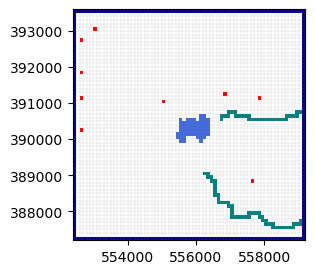

In [29]:
fig, ax = plt.subplots(figsize=(3, 3))  ; pmv = flopy.plot.PlotMapView(m, ax=ax)  ; lc = pmv.plot_grid(lw=0.1)
pmv.plot_bc("WEL", plotAll=True)  ; pmv.plot_bc("LAK", plotAll=True)  ; pmv.plot_bc("SFR", plotAll=True)  ;  pmv.plot_bc("CHD", plotAll=True)  

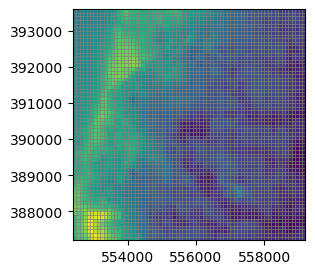

In [6]:
fig, ax=plt.subplots(figsize=(3, 3)) ; pmv=flopy.plot.PlotMapView(m,ax=ax) ; lc=pmv.plot_grid(lw=0.5) ; top=pmv.plot_array(m.dis.top.array)

### Exporting the model grid to a shapefile

In [7]:
m.modelgrid.write_shapefile(str(output_folder / 'pleasant_grid.shp'))

Text(0, 0.5, 'Elevation, in Meters')

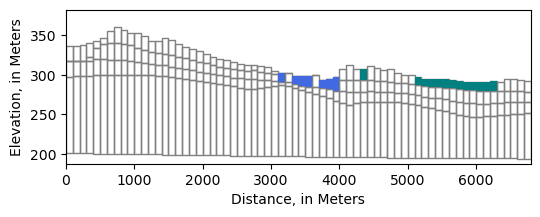

In [8]:
fig, ax = plt.subplots(figsize=(6, 2))         ; xs = flopy.plot.PlotCrossSection(model=m, line={"row": 30}, ax=ax)
lc = xs.plot_grid()  ; xs.plot_bc("LAK")  ; xs.plot_bc("SFR")
ax.set_xlabel(f'Distance, in {m.modelgrid.units.capitalize()}')  ; ax.set_ylabel(f'Elevation, in {m.modelgrid.units.capitalize()}')

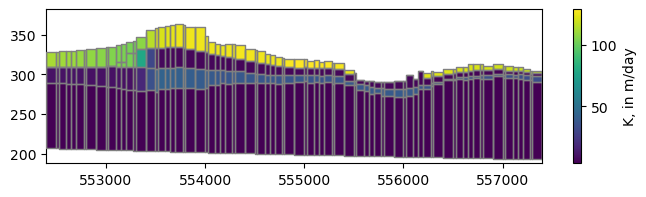

In [22]:
fig, ax = plt.subplots(figsize=(8, 2))
xs_line = [(552400, 393000), (552400 + 5000, 393000 - 4000)]
xs = flopy.plot.PlotCrossSection(model=m, line={"line": xs_line}, ax=ax, geographic_coords=True)
lc = xs.plot_grid(zorder=4) ; pc = xs.plot_array(m.npf.k.array)  ; fig.colorbar(pc, label='K, in m/day');

#### What if we want to look at cross sections for each row or column?
This code allows for every row or column to be visualized in cross section within the Jupyter Notebook session.

In [10]:
rec = m.rcha.recharge.array ;   print(rec.shape)

(13, 1, 64, 68)


Text(0.5, 0, 'Model stress period')

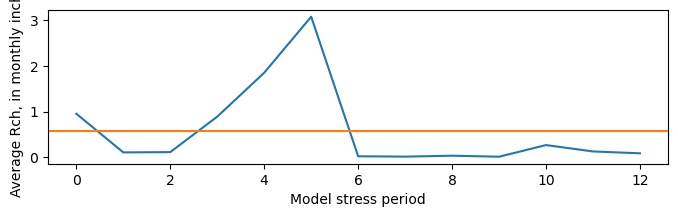

In [21]:
rch_inches = m.rcha.recharge.array[:, 0, :, :].mean(axis=(1, 2)) * 12 * 30.4 / .3048 
fig, ax = plt.subplots(figsize=(8, 2))  ; ax.plot(rch_inches)  ; ax.axhline(rch_inches.mean(), c='C1')
ax.set_ylabel(f"Average Rch, in monthly inches")          ; ax.set_xlabel("Model stress period")

#### Tabular data example: plot pumping by stress period
Most tabular input for the 'basic' stress packages (Constant Head, Drain, General Head, RIV, WEL, etc) are accessible via a ``stress_period_data`` attribute.   
* To access the data, we have to call another ``.data`` attribute, which gives us a dictionary of ``recarray``s by stress period.  
* Any one of these can be converted to a ``pandas.DataFrame`` individually, or we can make a dataframe of all of them with a simple loop.

In [15]:
dfs = []
for kper, df in m.wel.stress_period_data.get_dataframe().items():
    df['per'] = kper
    dfs.append(df)
df = pd.concat(dfs)  ; df.head() 

,cellid_layer,cellid_row,cellid_column,q,boundname,per
0,2,24,2,-396.867,pleasant_2-13-2,0
1,2,17,2,-409.900,pleasant_2-9-2,0
2,3,23,44,0.000,pleasant_3-12-23,0
3,3,25,26,0.000,pleasant_3-13-14,0
4,3,24,54,-878.654,pleasant_3-13-28,0


In [52]:
print(df.shape) ; sa = pd.DataFrame(df) ;  sa.to_csv (output_folder / "A1_Wells.csv")  ; print('Wells = ',sa.shape)

(81, 6)
Wells =  (81, 6)


Text(0.5, 0, 'Model stress period')

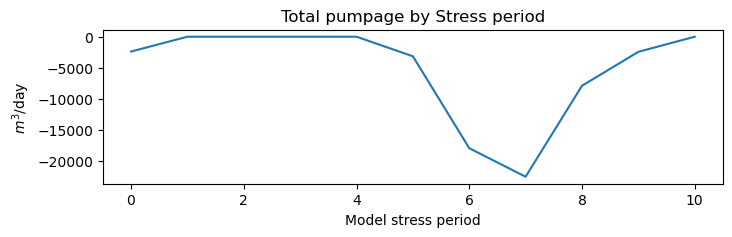

In [20]:
df.groupby('per').sum()['q'].plot(figsize=(8, 2))
plt.title('Total pumpage by Stress period')  ; plt.ylabel('$m^3$/day')  ; plt.xlabel('Model stress period')

Text(0, 0.5, 'm^3/day')

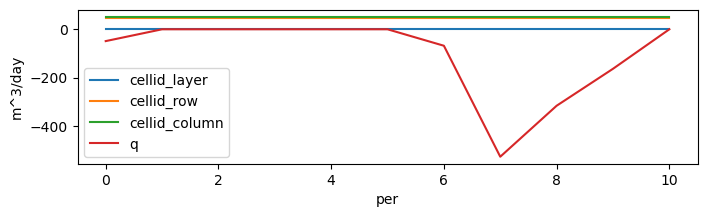

In [27]:
ax = df.groupby('boundname').get_group('pleasant_3-24-27').plot(x='per', figsize=(8, 2))   ; ax.set_ylabel('m^3/day')

In [34]:
sim.run_simulation(silent=True)

(True, [])

In [46]:
from flopy.utils.postprocessing import get_water_table
hds = m.output.head().get_data(kstpkper=(0, 0))   ;   wt = get_water_table(hds)    ; print('H =', hds.shape)

H = (4, 64, 68)


In [51]:
row = hds     [0] ; sa = pd.DataFrame(row) ;  sa.to_csv (output_folder / "A2_Heads_H0.csv")  ; print('A2_Heads_H0',sa.shape)

A2_Heads_H0 (64, 68)


In [42]:
lak_output = pd.read_csv(sim_ws / 'lake1.obs.csv')  ; stage   = lak_output['STAGE'][0]  
sa = pd.DataFrame(lak_output)  ;  sa.to_csv (output_folder / "A3_lak_output.csv")             ; print('A3_lak_output',sa.shape)

cnd = pd.DataFrame(m.lak.connectiondata.array)      ; k, i, j = zip( *cnd ['cellid'])  ; wt[i, j] = stage

sfr_stage = m.sfr.output.stage().get_data()[0, 0, :] 
sfr_k, sfr_i, sfr_j  = zip(*m.sfr.packagedata.array['cellid'])
wt [   sfr_i, sfr_j] = sfr_stage

cbc = m.output.budget()        ; lak = cbc.get_data(text='lak', full3D=True)[0].sum(axis=0)   ; sfr = cbc.get_data(text='sfr', full3D=True)[0]

In [57]:
print(wt.shape) ; sa = pd.DataFrame(wt) ;  sa.to_csv (output_folder / "A4_Lake_wt.csv")  

(64, 68)


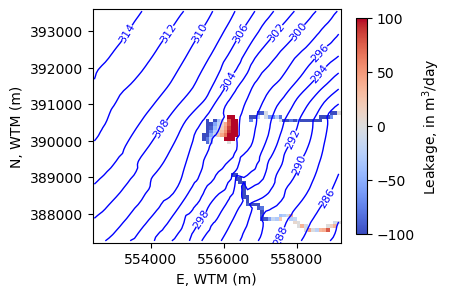

In [65]:
levels=np.arange(280, 315, 2)
fig, ax = plt.subplots(figsize=(4, 4)) ; pmv = flopy.plot.PlotMapView(m, ax=ax) ; ctr = pmv.contour_array(wt, levels=levels, linewidths=1, colors='b')
labels = pmv.ax.clabel(ctr, inline=True, fontsize=8, inline_spacing=1) ; vmin, vmax = -100, 100
im = pmv.plot_array(lak, cmap='coolwarm', vmin=vmin, vmax=vmax)
im = pmv.plot_array(sfr.sum(axis=0), cmap='coolwarm', vmin=vmin, vmax=vmax)
cb = fig.colorbar(im, shrink=0.7, label='Leakage, in m$^3$/day') ; ax.set_ylabel("N, WTM (m)") ; ax.set_xlabel("E, WTM (m)") ; ax.set_aspect(1)

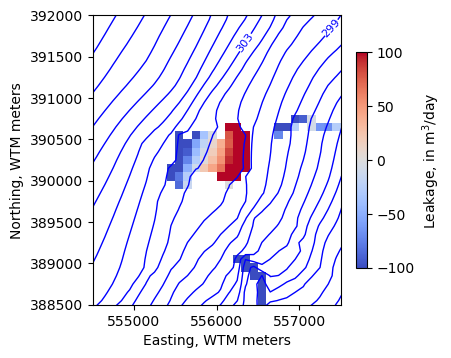

In [68]:
levels=np.arange(280, 315, 1)                                                     ; new_extent = (554500, 557500, 388500, 392000)
fig,ax = plt.subplots(figsize=(4,4)) ; pmv=flopy.plot.PlotMapView(m,ax=ax,extent = new_extent)          ; vmin, vmax = -100, 100
ctr = pmv.contour_array(wt, levels=levels, linewidths=1, colors='b') ; labels = pmv.ax.clabel(ctr, inline=True, fontsize=8, inline_spacing=1)
im = pmv.plot_array(lak, cmap='coolwarm', vmin=vmin, vmax=vmax)
im = pmv.plot_array(sfr.sum(axis=0), cmap='coolwarm', vmin=vmin, vmax=vmax)
cb = fig.colorbar(im, shrink=0.7, label='Leakage, in m$^3$/day')
ax.set_ylabel("Northing, WTM meters") ; ax.set_xlabel("Easting, WTM meters")  ; ax.set_aspect(1)

from flopy.export.utils import export_array
export_array(m.modelgrid, str(output_folder / 'water_table.tif'), wt)

(np.float64(11.193730134934754), np.float64(-76.35338698486248))

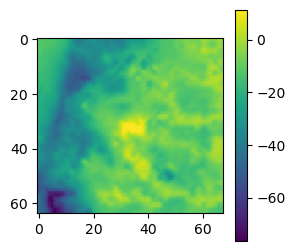

In [83]:
op = wt - m.dis.top.array    ; plt.figure(figsize=(3, 3), dpi=100)  ; plt.imshow(op); plt.colorbar()  ; op.max(), op.min()

In [84]:
export_array(m.modelgrid, str(output_folder / 'op.tif'), op)

Text(0, 0.5, 'Elevation, in Meters')

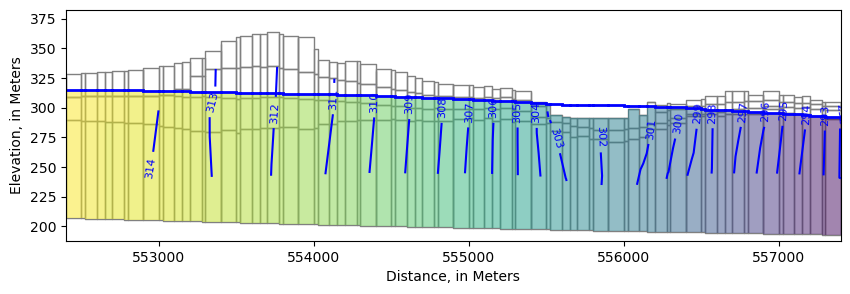

In [80]:
fig, ax = plt.subplots(figsize=(10, 3))                ; xs_line = [(552400, 393000), (552400 + 5000, 393000 - 4000)]
xs = flopy.plot.PlotCrossSection(model=m, line={"line" : xs_line}, ax=ax,geographic_coords=True)  #line={"row": 32},
lc  = xs.plot_grid()  ; pc = xs.plot_array(hds, head=hds, alpha=0.5, masked_values=[1e30])
ctr = xs.contour_array (hds, head=hds,  levels=levels,  colors="b",  masked_values=[1e30])
surf = xs.plot_surface(wt, masked_values=[1e30], color="blue", lw=2) ; labels = pmv.ax.clabel(ctr, inline=True, fontsize=8, inline_spacing=5)
ax.set_xlabel(f'Distance, in {m.modelgrid.units.capitalize()}') ; ax.set_ylabel(f'Elevation, in {m.modelgrid.units.capitalize()}')

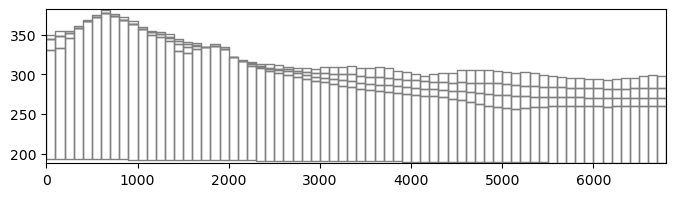

In [86]:
fig, ax = plt.subplots(figsize=(8, 2))   ; xs = flopy.plot.PlotCrossSection(model=m, line={"row": 62}, ax=ax)  ; lc = xs.plot_grid()

In [103]:
headobs = pd.DataFrame(m.obs_3.output.obs().get_data()) ;      # headobs  # m.get_package_list()    
headobs.to_csv (output_folder / "A5_OBS_3.csv")                # or   headobs = pd.read_csv(sim_ws / 'pleasant.head.obs')) 

### **Boundnames**

In [ ]:
CHD_Bound = pd.read_csv(sim_ws  /  'external/chd_001.dat'  , delim_whitespace=True)
CHD_Bound.to_csv (output_folder /  "A6_CHD_Bound.csv") 
df        = pd.read_csv(sim_ws  /  'pleasant.chd.obs.output.csv')  ; df.index = df['time']  ;  # df.head()
df.to_csv        (output_folder /  "A7_Bound_2_ordered.csv")      # ModflowGwfchd(model, loading_

In [110]:
from flopy.utils import Mf6ListBudget 

In [ ]:
mfl = Mf6ListBudget(sim_ws    / 'pleasant.list')             ; flux,_vol = mfl.get_dataframes(start_datetime='2011-12-30')  ; 
flux,_vol.to_csv(output_folder / "A8_Q.csv")   # flux.head()
# ax = flux['PERCENT_DISCREPANCY'].plot() ; ax.set_ylabel('Percent mass balance error')

Text(0, 0.5, 'Simulated Flux, in $m^3/d$')

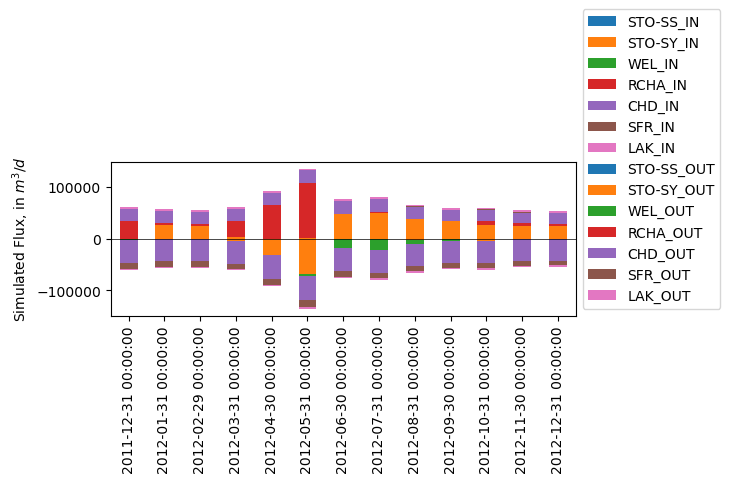

In [125]:
fig, ax = plt.subplots(figsize=(6, 2))
in_cols = ['STO-SS_IN', 'STO-SY_IN', 'WEL_IN', 'RCHA_IN', 'CHD_IN', 'SFR_IN', 'LAK_IN']
out_cols = [c.replace('_IN', '_OUT') for c in in_cols]
flux[in_cols].plot.bar(stacked=True, ax=ax)
(-flux[out_cols]).plot.bar(stacked=True, ax=ax)
ax.legend(loc='lower left', bbox_to_anchor=(1, 0) )
ax.axhline(0, lw=0.5, c='k')
ax.set_ylabel('Simulated Flux, in $m^3/d$')

### References

Fienen, M. N., Haserodt, M. J., Leaf, A. T., and Westenbroek, S. M. (2022). Simulation of regional groundwater flow and groundwater/lake interactions in the central Sands, Wisconsin. U.S. Geological Survey Scientific Investigations Report 2022-5046. doi:10.3133/sir20225046

Fienen, M. N., Haserodt, M. J., and Leaf, A. T. (2021). MODFLOW models used to simulate groundwater flow in the Wisconsin Central Sands Study Area, 2012-2018. New York: U.S. Geological Survey Data Release. doi:10.5066/P9BVFSGJ